In [1]:
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
import seaborn as sns
from tabulate import tabulate
import re
sns.set(font_scale=1.8, style="whitegrid")

In [2]:
seeds = ["10","20","30","40","50","60"]
tempos = ["010","020", "030"]
salvarGraficos = False
confianca = 95
intervalosTempo = [("010", 100, 200), ("020", 300, 400), ("030", 550, 650)]

In [3]:
dfHW_e = pd.DataFrame()
dfSW_e = pd.DataFrame()
for seed in seeds:
    dfHW_e = pd.read_table("logs/seed"+(seed)+"/010/estatica/010estatica-"+(seed)+"-switch-stats-hw.log", sep="\s+")
    dfSW_e = pd.read_table("logs/seed"+(seed)+"/010/estatica/010estatica-"+(seed)+"-switch-stats-sw.log", sep="\s+")
remover = ['MetDrps','MetMods','GroMods','PktsIn','PktsOut','MetEntr','MetUsag','GroEntr','GroUsag','BufPkts','BufUsag']
for item in remover:
    del dfHW_e[item]
    del dfSW_e[item]
dfHW_e['Switch'] = 'HW'
dfSW_e['Switch'] = 'SW'
dfSwitch_e = pd.concat([dfHW_e, dfSW_e], ignore_index=True)

Text(0.5,1,'Estatica - 010')

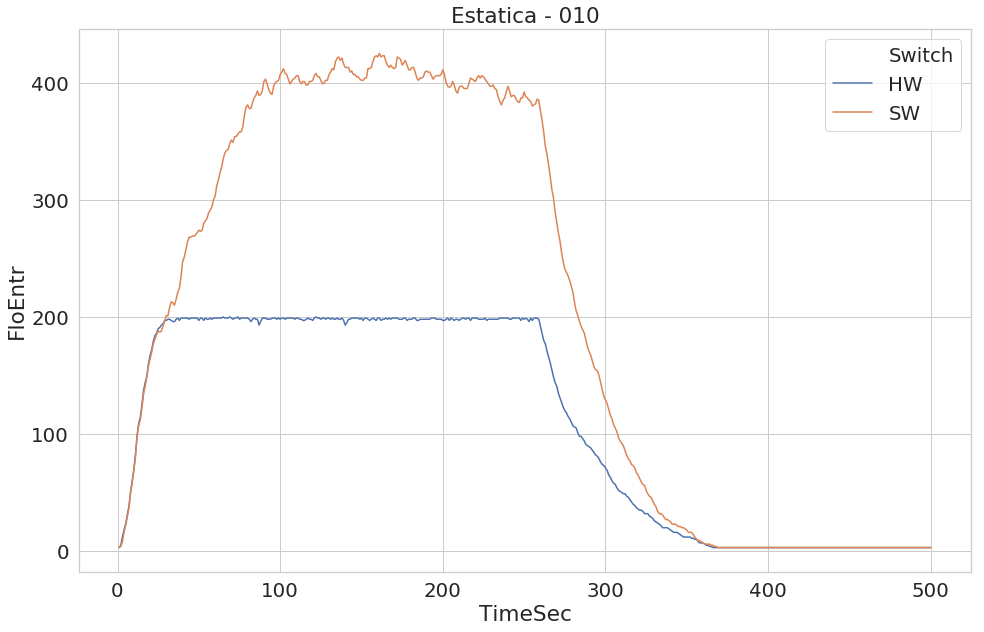

In [4]:
plt.figure(figsize=(16, 10))
ax = sns.lineplot(x="TimeSec", y="FloEntr",hue="Switch",data=dfSwitch_e)
plt.title('Estatica - 010')

In [5]:
dfHW_e = pd.DataFrame()
dfSW_e = pd.DataFrame()
for seed in seeds:
    dfHW_e = pd.read_table("logs/seed"+(seed)+"/020/estatica/020estatica-"+(seed)+"-switch-stats-hw.log", sep="\s+")
    dfSW_e = pd.read_table("logs/seed"+(seed)+"/020/estatica/020estatica-"+(seed)+"-switch-stats-sw.log", sep="\s+")
remover = ['MetDrps','MetMods','GroMods','PktsIn','PktsOut','MetEntr','MetUsag','GroEntr','GroUsag','BufPkts','BufUsag']
for item in remover:
    del dfHW_e[item]
    del dfSW_e[item]
dfHW_e['Switch'] = 'HW'
dfSW_e['Switch'] = 'SW'
dfSwitch_e = pd.concat([dfHW_e, dfSW_e], ignore_index=True)

Text(0.5,1,'Estatica - 020')

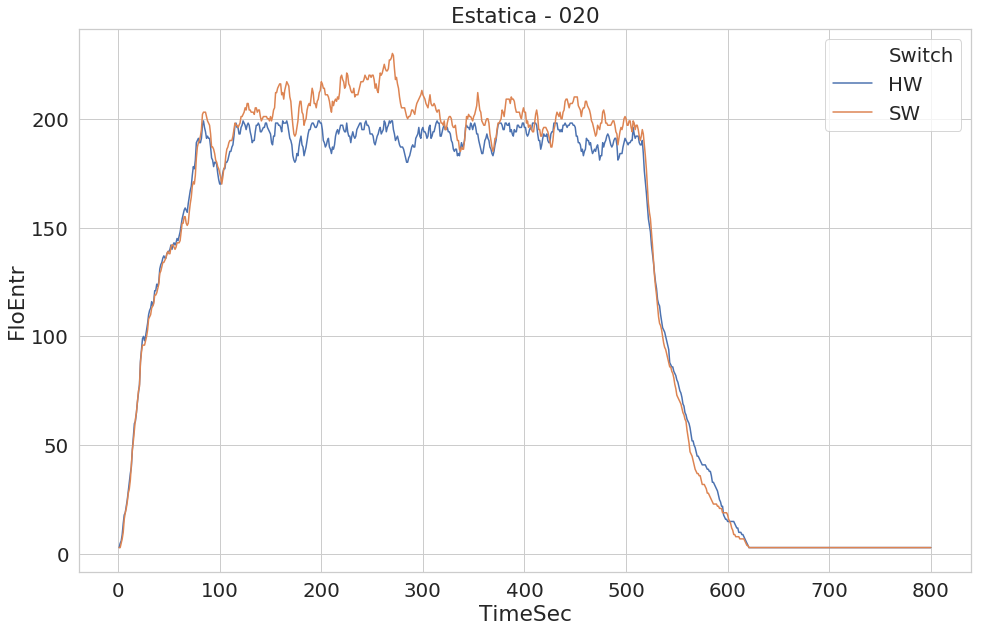

In [6]:
plt.figure(figsize=(16, 10))
ax = sns.lineplot(x="TimeSec", y="FloEntr",hue="Switch",data=dfSwitch_e)
plt.title('Estatica - 020')

In [7]:
dfHW_e = pd.DataFrame()
dfSW_e = pd.DataFrame()
for seed in seeds:
    dfHW_e = pd.read_table("logs/seed"+(seed)+"/030/estatica/030estatica-"+(seed)+"-switch-stats-hw.log", sep="\s+")
    dfSW_e = pd.read_table("logs/seed"+(seed)+"/030/estatica/030estatica-"+(seed)+"-switch-stats-sw.log", sep="\s+")
remover = ['MetDrps','MetMods','GroMods','PktsIn','PktsOut','MetEntr','MetUsag','GroEntr','GroUsag','BufPkts','BufUsag']
for item in remover:
    del dfHW_e[item]
    del dfSW_e[item]
dfHW_e['Switch'] = 'HW'
dfSW_e['Switch'] = 'SW'
dfSwitch_e = pd.concat([dfHW_e, dfSW_e], ignore_index=True)

Text(0.5,1,'Estatica - 030')

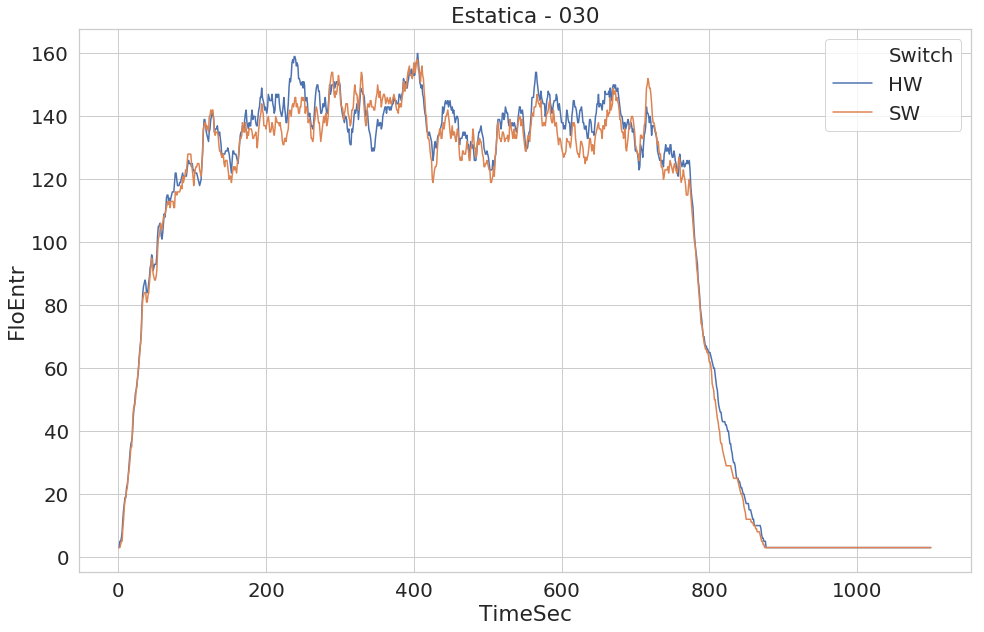

In [8]:
plt.figure(figsize=(16, 10))
ax = sns.lineplot(x="TimeSec", y="FloEntr",hue="Switch",data=dfSwitch_e)
plt.title('Estatica - 030')

In [9]:
dfHW_d = pd.DataFrame()
dfSW_d = pd.DataFrame()
for seed in seeds:
    dfHW_d = pd.read_table("logs/seed"+(seed)+"/010/dinamica/010dinamica-"+(seed)+"-switch-stats-hw.log", sep="\s+")
    dfSW_d = pd.read_table("logs/seed"+(seed)+"/010/dinamica/010dinamica-"+(seed)+"-switch-stats-sw.log", sep="\s+")
remover = ['MetDrps','MetMods','GroMods','PktsIn','PktsOut','MetEntr','MetUsag','GroEntr','GroUsag','BufPkts','BufUsag']
for item in remover:
    del dfHW_d[item]
    del dfSW_d[item]
dfHW_d['Switch'] = 'HW'
dfSW_d['Switch'] = 'SW'
dfSwitch_d = pd.concat([dfHW_d, dfSW_d], ignore_index=True)

Text(0.5,1,'Dinamica - 010')

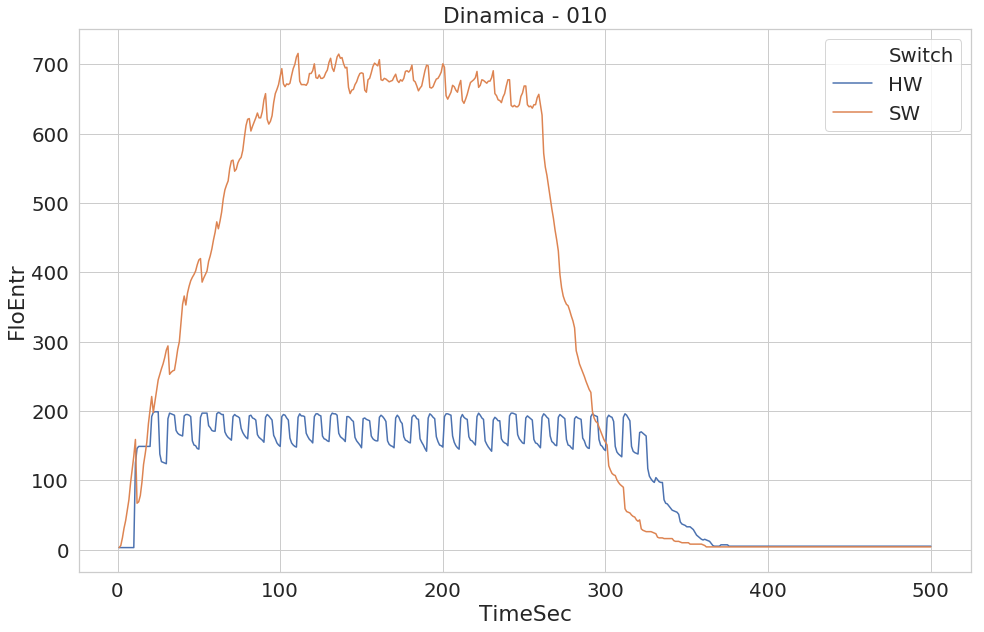

In [10]:
plt.figure(figsize=(16, 10))
ax = sns.lineplot(x="TimeSec", y="FloEntr",hue="Switch",data=dfSwitch_d)
plt.title('Dinamica - 010')

In [11]:
dfHW_d = pd.DataFrame()
dfSW_d = pd.DataFrame()
for seed in seeds:
    dfHW_d = pd.read_table("logs/seed"+(seed)+"/020/dinamica/020dinamica-"+(seed)+"-switch-stats-hw.log", sep="\s+")
    dfSW_d = pd.read_table("logs/seed"+(seed)+"/020/dinamica/020dinamica-"+(seed)+"-switch-stats-sw.log", sep="\s+")
remover = ['MetDrps','MetMods','GroMods','PktsIn','PktsOut','MetEntr','MetUsag','GroEntr','GroUsag','BufPkts','BufUsag']
for item in remover:
    del dfHW_d[item]
    del dfSW_d[item]
dfHW_d['Switch'] = 'HW'
dfSW_d['Switch'] = 'SW'
dfSwitch_d = pd.concat([dfHW_d, dfSW_d], ignore_index=True)

Text(0.5,1,'Dinamica - 020')

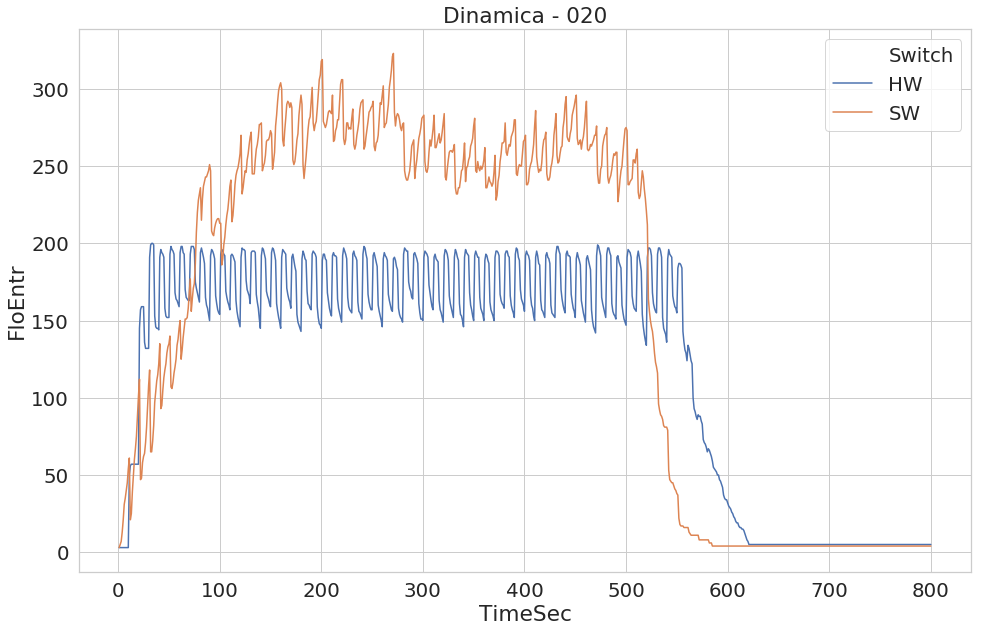

In [12]:
plt.figure(figsize=(16, 10))
ax = sns.lineplot(x="TimeSec", y="FloEntr",hue="Switch",data=dfSwitch_d)
plt.title('Dinamica - 020')

In [13]:
dfHW_d = pd.DataFrame()
dfSW_d = pd.DataFrame()
for seed in seeds:
    dfHW_d = pd.read_table("logs/seed"+(seed)+"/030/dinamica/030dinamica-"+(seed)+"-switch-stats-hw.log", sep="\s+")
    dfSW_d = pd.read_table("logs/seed"+(seed)+"/030/dinamica/030dinamica-"+(seed)+"-switch-stats-sw.log", sep="\s+")
remover = ['MetDrps','MetMods','GroMods','PktsIn','PktsOut','MetEntr','MetUsag','GroEntr','GroUsag','BufPkts','BufUsag']
for item in remover:
    del dfHW_d[item]
    del dfSW_d[item]
dfHW_d['Switch'] = 'HW'
dfSW_d['Switch'] = 'SW'
dfSwitch_d = pd.concat([dfHW_d, dfSW_d], ignore_index=True)

Text(0.5,1,'Dinamica - 030')

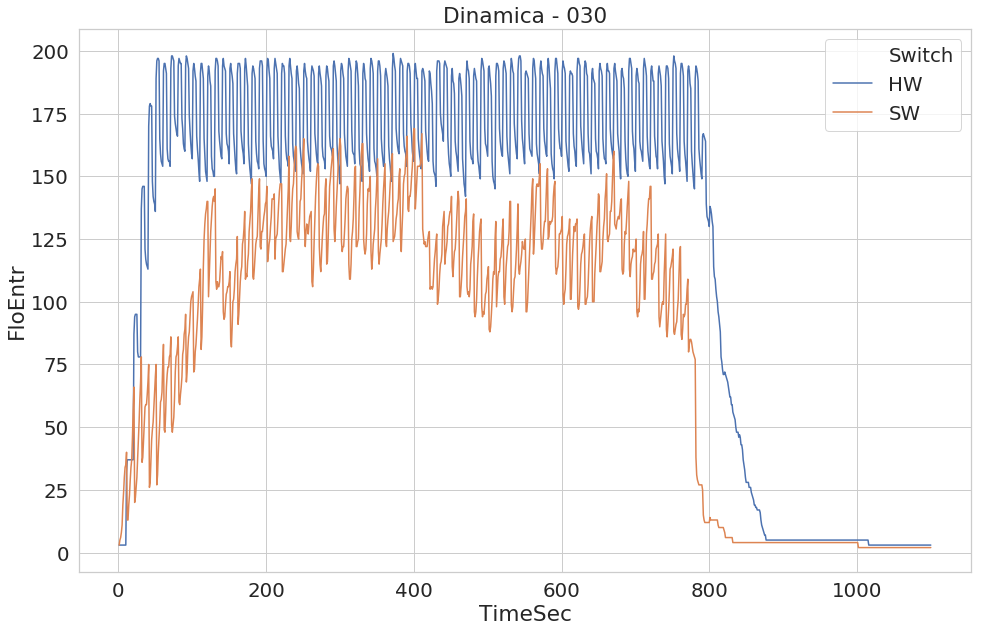

In [14]:
plt.figure(figsize=(16, 10))
ax = sns.lineplot(x="TimeSec", y="FloEntr",hue="Switch",data=dfSwitch_d)
plt.title('Dinamica - 030')

In [15]:
#Arquivos de log de bloqueios
bloqueio_d = pd.DataFrame()
bloqueio_e = pd.DataFrame()
for seed in seeds:
    for tempo in tempos:
        bloqueio_dtemp = pd.read_table("logs/seed"+(seed)+"/"+tempo+"/dinamica/"+tempo+"dinamica-"+(seed)+"-regrasBloqueadas.txt", sep="\s+")
        bloqueio_etemp = pd.read_table("logs/seed"+(seed)+"/"+tempo+"/estatica/"+tempo+"estatica-"+(seed)+"-regrasBloqueadas.txt", sep="\s+")
        bloqueio_dtemp['Seed'] = seed
        bloqueio_etemp['Seed'] = seed
        bloqueio_etemp['TempoChegada'] = tempo
        bloqueio_dtemp['TempoChegada'] = tempo
        bloqueio_dtemp['Politica'] = 'Dinamica'
        bloqueio_etemp['Politica'] = 'Estatica'
        bloqueio_d = pd.concat([bloqueio_d, bloqueio_dtemp], ignore_index=True)
        bloqueio_e = pd.concat([bloqueio_e, bloqueio_etemp], ignore_index=True)

dfBloq = pd.concat([bloqueio_d, bloqueio_e], ignore_index=True)
del dfBloq['Time:s']

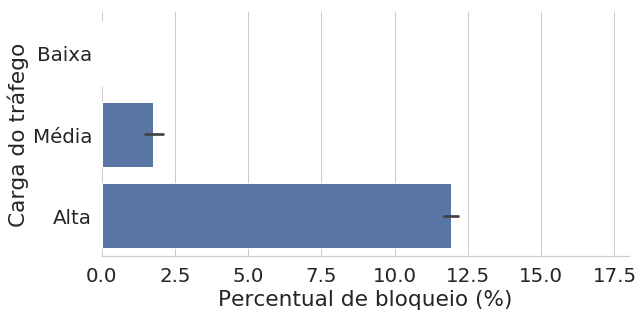

In [16]:
#Grafico de percentual de bloqueio
gpb = dfBloq.groupby(["Seed", "TempoChegada", "Politica"]).max()
gpb.reset_index(inplace=True)
gpb["TaxaBloqueio"] = gpb["RegrasBloqueadas"]/2/float(2500)*100
gpb["NomeTempo"] = gpb["TempoChegada"].map({"010": "Alta", "020": "Média", "030": "Baixa"})
sns_plt = sns.catplot(legend=False, height=4.5, aspect=2, x="TaxaBloqueio", y="NomeTempo", kind="bar", orient="h", hue="Politica", hue_order=["Estatica"],order=["Baixa", "Média", "Alta"], ci=confianca, data=gpb)
#sns_plt.fig.suptitle('Taxa de bloqueio por carga', y=1.05)
sns_plt.set(xlim=(0, 18))
sns_plt.set_axis_labels("Percentual de bloqueio (%)","Carga do tráfego")
sns_plt.despine(left=True)

In [17]:
#Lendo os arquivos de ping
def pings(dfP, metodo, switch):
    for s in range(len(seeds)):
        for tempo in tempos:                 
            path = "logs/seed"+(str((s+1)*10))+"/"+(tempo)+"/"+(metodo)+"/"+(tempo)+(metodo)+"-"+(str((s+1)*10))+"-ping"+switch+".txt" #caminho do arquivo
            with open(path) as stream:#Abre o arquivo
                times = [] #lista que armazenara todos os pings para coloca-los posteriormente em um series->dataframe
                next(stream)  # Ignora a primeira linha do arquivo de entrada
                for line in stream: #Pega todas as linhas
                    string = line.split(" ") #String eh uma lista com cada palavra da linha
                    if(line != "Request timed out\n"): #Se a linha tiver o ping
                        for i in range(0,len(string)): #Para cada palavra na lista string, procura "time"
                            if(re.match(r'time', string[i])): #Pega somente os valores numericos da palavra
                                time = re.findall(r'\d.+', string[i])
                                times.append(float(time[0])) #Transforma-os para float e coloca-os na lista times
                series = pd.Series(times) #Transforma a lista em uma Series
                ds = pd.DataFrame(series, columns=['Ping']) # E por fim em um dataframe
                ds['Seed'] = seeds[s]
                ds['Tempo'] = tempo
                ds['Política'] = metodo
                ds['Switch'] = switch
                dfP = pd.concat([dfP, ds])
    return dfP

dfPing = pd.DataFrame(columns=['Ping', 'Seed', 'Tempo', 'Política', 'Switch'])
dfPPIHW = pings(dfPing, 'estatica', 'HW')
dfPPISW = pings(dfPing, 'estatica', 'SW')
dfPSWHW = pings(dfPing, 'dinamica', 'HW')
dfPSWSW = pings(dfPing, 'dinamica', 'SW')
dfPing = pd.concat([dfPing, dfPPIHW, dfPPISW, dfPSWHW, dfPSWSW])
dfPing.reset_index(inplace=True)
del dfPing['index']
#dfPing.to_csv(r'pandas.txt', index=None, sep=' ', mode='a')

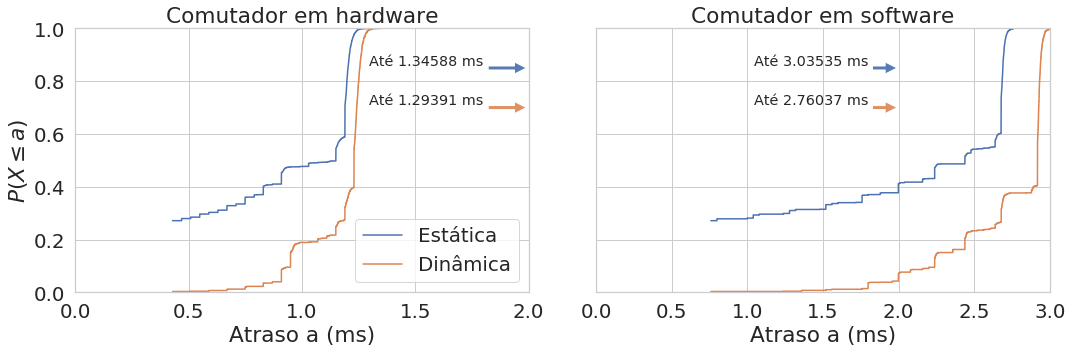

In [18]:
#CDF do ping
#Query
dfPingHW_CAPI = dfPing.query("Política == 'estatica' and Tempo == '010' and Switch == 'HW'")
dfPingHW_CASW = dfPing.query("Política == 'dinamica' and Tempo == '010' and Switch == 'HW'")
dfPingSW_CAPI = dfPing.query("Política == 'estatica' and Tempo == '010' and Switch == 'SW'")
dfPingSW_CASW = dfPing.query("Política == 'dinamica' and Tempo == '010' and Switch == 'SW'")
#HW
hw_a = dfPingHW_CAPI.Ping.to_numpy()
hw_b = dfPingHW_CASW.Ping.to_numpy()
maxHW = [hw_a.max(), hw_b.max()]
hw_x = np.sort(hw_a)
hw_x1 = np.sort(hw_b)
hw_ecdf = sm.distributions.ECDF(hw_a)
hw_ecdf1 = sm.distributions.ECDF(hw_b)
hw_y = hw_ecdf(hw_x)
hw_y1 = hw_ecdf1(hw_x1)
#SW
sw_a = dfPingSW_CAPI.Ping.to_numpy()
sw_b = dfPingSW_CASW.Ping.to_numpy()
maxSW = [sw_a.max(), sw_b.max()]
sw_x = np.sort(sw_a)
sw_x1 = np.sort(sw_b)
sw_ecdf = sm.distributions.ECDF(sw_a)
sw_ecdf1 = sm.distributions.ECDF(sw_b)
sw_y = sw_ecdf(sw_x)
sw_y1 = sw_ecdf1(sw_x1)
#Graficos
#HW
plt.subplot(1, 2, 1)
plt.step(hw_x, hw_y, where='post', label="Estática")
plt.step(hw_x1, hw_y1, where='post', label="Dinâmica")
plt.ylabel(r'$P(X \leq a)$')
plt.xlabel(r'Atraso a (ms)')
plt.xlim(0, 2)
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.title('Comutador em hardware')
maiorPing = np.max(maxHW)
plt.annotate('Até '+str(maxHW[1])+' ms', xy=(2, 0.85), xytext=(1.8, 0.85),size='x-large',
            arrowprops=dict(facecolor='#587bb4', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom')
plt.annotate('Até '+str(maxHW[0])+' ms', xy=(2, 0.7), xytext=(1.8, 0.7),size='x-large',
            arrowprops=dict(facecolor='#e09163', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom')
#SW
plt.subplot(1, 2, 2)
plt.step(sw_x, sw_y, where='post', label="Estática")
plt.step(sw_x1, sw_y1, where='post', label="Dinâmica")
#plt.ylabel(r'$P(X \leq x)$')
plt.xlabel(r'Atraso a (ms)')
plt.xlim(0, 3)
plt.ylim(0, 1)
#plt.legend(loc='best')
plt.title('Comutador em software')
#Tamanho
fig = plt.gcf()
fig.set_size_inches(15, 5)
fig.tight_layout()
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([])
maiorPing = np.max(maxSW)
plt.annotate('Até '+str(maxSW[1])+' ms', xy=(2, 0.85), xytext=(1.8, 0.85), size='x-large',
            arrowprops=dict(facecolor='#587bb4', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom')
plt.annotate('Até '+str(maxSW[0])+' ms', xy=(2, 0.7), xytext=(1.8, 0.7), size='x-large',
            arrowprops=dict(facecolor='#e09163', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom')
if (salvarGraficos):
    plt.savefig('Graficos/pingCargaAlta.pdf')
plt.show()